# **1. Import Libraries**

In [2]:
!pip install e2cnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 4.9 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from e2cnn import gspaces
from e2cnn import nn as enn

# **2. Define the Neural Network Architecture**

In [4]:
# Define the EquivariantCNN
class EquivariantCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r2_act = gspaces.Rot2dOnR2(N=8)

        # Input: 1 channel (trivial representation)
        self.input_type = enn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.output_type = enn.FieldType(self.r2_act, 16 * [self.r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
        enn.R2Conv(self.input_type, self.output_type, kernel_size=5, padding=2, bias=False),
        enn.InnerBatchNorm(self.output_type),  # ✅ BatchNorm added here
        enn.ReLU(self.output_type, inplace=True),
        enn.PointwiseMaxPool(self.output_type, 2)
        )

        self.block2 = enn.SequentialModule(
        enn.R2Conv(self.output_type, self.output_type, kernel_size=3, padding=1, bias=False),
        enn.InnerBatchNorm(self.output_type),  # ✅ BatchNorm added here too
        enn.ReLU(self.output_type, inplace=True),
        enn.PointwiseMaxPool(self.output_type, 2)
        )

        self.gpool = enn.GroupPooling(self.output_type)
        self.fc = torch.nn.Linear(16, 1)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = self.gpool(x)
        x = x.tensor.mean(dim=(-1, -2))
        return self.fc(x).squeeze()

# **3. Data Simulation and Split**

In [5]:
# Simulate dataset
def simulate_equivariant_data(n_samples=1000):
    X = np.zeros((n_samples, 1, 64, 64))
    y = np.random.randint(1, 6, size=(n_samples,))
    for i in range(n_samples):
        for _ in range(y[i]):
            x, y_coord = np.random.randint(5, 59, size=2)
            X[i, 0, x-2:x+2, y_coord-2:y_coord+2] = 1.0  # Planet-like blobs
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Load data and normalize targets
X, y = simulate_equivariant_data()
y_norm = (y - 1) / 4  # Normalize to [0, 1]

# **4. Train the model and Plot Predictions**

In [6]:
# Instantiate model
model = EquivariantCNN()

# Training function
def train_equivariant_model(model, X, y, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1} — Loss: {loss.item():.4f}")

# Train the model on normalized targets
train_equivariant_model(model, X, y_norm, epochs=100)

# Evaluate model
model.eval()
with torch.no_grad():
    preds = model(X).detach()

# Unnormalize predictions and ground truth
preds = preds * 4 + 1
y_true = y_norm * 4 + 1

/usr/local/lib/python3.11/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  full_mask[mask] = norms.to(torch.uint8)


Epoch 1 — Loss: 0.6358
Epoch 11 — Loss: 0.0981
Epoch 21 — Loss: 0.0288
Epoch 31 — Loss: 0.0304
Epoch 41 — Loss: 0.0260
Epoch 51 — Loss: 0.0249
Epoch 61 — Loss: 0.0235
Epoch 71 — Loss: 0.0221
Epoch 81 — Loss: 0.0209
Epoch 91 — Loss: 0.0198


# **5. Plot predictions**

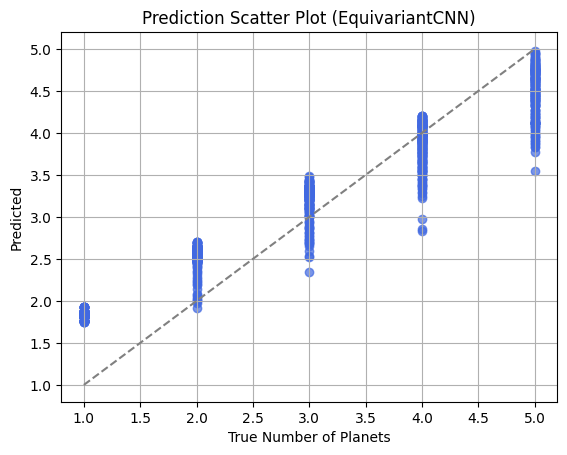

In [7]:
# Plot predictions
plt.scatter(y_true.numpy(), preds.numpy(), color="royalblue", alpha=0.7)
plt.plot([1, 5], [1, 5], '--', color='gray')
plt.xlabel("True Number of Planets")
plt.ylabel("Predicted")
plt.title("Prediction Scatter Plot (EquivariantCNN)")
plt.grid(True)
plt.show()

# **6. Testing the model on samples**

In [8]:
# Print sample results
for i in range(10):  # only show first 10
    print(f"Sample {i+1}: True = {int(y_true[i].item())}, Predicted ≈ {preds[i].item():.2f}")

Sample 1: True = 5, Predicted ≈ 4.73
Sample 2: True = 1, Predicted ≈ 1.81
Sample 3: True = 1, Predicted ≈ 1.86
Sample 4: True = 5, Predicted ≈ 4.74
Sample 5: True = 4, Predicted ≈ 3.95
Sample 6: True = 1, Predicted ≈ 1.82
Sample 7: True = 4, Predicted ≈ 4.13
Sample 8: True = 2, Predicted ≈ 2.58
Sample 9: True = 1, Predicted ≈ 1.81
Sample 10: True = 1, Predicted ≈ 1.86
